In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

## An example problem

We consider an example problem describing the behavior uni-directional deformation in some material under linear kinematic hardening conditions. We choose dimension-less material parameters
$$E = 10,\qquad H = 1,\qquad \sigma_Y = 5$$
The material stress/strain relations are described by
$$ \sigma = E(\varepsilon - \varepsilon_p), \qquad \hat \sigma = \sigma - H \varepsilon_p$$
The yield conditions reads
$$ \hat f(\hat \sigma) = |\hat \sigma| - \sigma_Y \leq 0$$

In [27]:
E = 10
H = 1

sigmaY = 0.5

def fhat(sigmahat): return np.abs(sigmahat) - sigmaY

The stress-strain curve for an incrementally applied load up to strain $\varepsilon = 0.2$ is known analytically, and plotted below

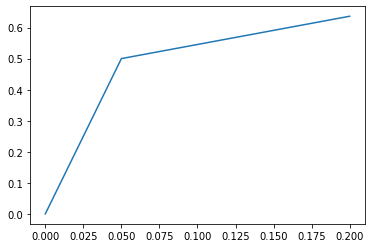

In [28]:
def stress(strain):
    if E*strain < sigmaY: return E*strain
    else: return sigmaY + H*E/(H+E)*(strain-sigmaY/E)


eps_analytic = np.linspace(0,0.2,201)
sigma_analytic = [ stress(strain) for strain in eps_analytic]

plt.plot(eps_analytic, sigma_analytic)

### Strain-driven loading and the return-map

We devise a procedure for computing the behavior of the material in a strain-driven setup. The strain is increased in 10 load steps up to $\varepsilon=0.2$. In each load step, the stress is evaluated via the return-mapping algorithm (see e.g. Simo and Hughes, 2006):

* given the new strain value $\varepsilon_{n+1}$ and plastic strain computed in the last iteration $\varepsilon_{p,n}$,
* compute trial stress for trial plastic strain update 
$$\Delta \varepsilon_p^{trial} = 0,\qquad \sigma^{trial} = E(\varepsilon_{n+1} - \varepsilon_{p,n})$$
* compute trial driving stress and check yield condition, 
$$\hat \sigma^{trial} = \hat \sigma - H \varepsilon_{p,n},\qquad \hat f(\hat \sigma^{trial})$$
* if yield condition is satisfied, $\hat f(\hat \sigma^{trial}) \leq 0$, set $\sigma = \sigma^{trial}$ and $\varepsilon_{p,n+1} = \varepsilon_{p,n}$: _elastic step_
* if yield condition is not satisfied, compute the return map $\Delta \varepsilon_p$ as discussed below, and set $\varepsilon_{p,n+1} = \varepsilon_{p,n} + \Delta \varepsilon_p$ and $\sigma = E(\varepsilon_{n+1} - \varepsilon_{p,n+1})$: _plastic step_

#### The return map

The return map specifies the rate $\Delta \varepsilon_p$ for given driving stress $\hat \sigma$. Here, the Karush-Kuhn-Tucker conditions are respected,
$$ \Delta \gamma \geq 0, \qquad \hat f(\hat \sigma) \leq 0, \qquad \Delta \gamma\, \hat f(\hat \sigma) = 0,$$
and in case of plastic flow, the plastic update is in direction normal to the yield surface
$$\Delta \varepsilon_p = \Delta \gamma \frac{\partial \hat f}{\partial \hat \sigma} = \Delta \gamma \operatorname{sign}(\hat \sigma)$$
This form of update implies for the driving stress
$$\hat \sigma = \hat \sigma^{trial} - (E+H) \Delta \gamma \operatorname{sign}(\hat \sigma)$$
or 
$$|\hat \sigma| \operatorname{sign}(\hat \sigma)  = |\hat \sigma^{trial}| \operatorname{sign}(\hat \sigma^{trial}) - (E+H) \Delta \gamma \operatorname{sign}(\hat \sigma)$$
If $\operatorname{sign}(\hat \sigma)  = \operatorname{sign}(\hat \sigma^{trial})$, what we expect in the algorithm, we deduce
$$|\hat \sigma|   = |\hat \sigma^{trial}|  - (E+H) \Delta \gamma $$
This expression for the absolute value is inserted in the yield function, which is subsequently set to zero,
$$\hat f(\hat \sigma) = |\hat \sigma| - \sigma_Y = |\hat \sigma^{trial}|  - (E+H) \Delta \gamma - \sigma_Y = 0$$
Finally, we arrive at the plastic strain update
$$
\Delta \gamma = \frac{\hat f(\hat \sigma^{trial})}{E+H},\qquad \Delta \varepsilon_p = \Delta \gamma\, \operatorname{sign}(\hat \sigma)$$

In [29]:
def returnmap(eps, epsp):
    sigmahat_trial = E*(eps - epsp)- H*epsp
    f_trial = fhat( sigmahat_trial)

    if f_trial < 0:
        return 0

    else:
        deltagamma = f_trial/(E+H)
        delta_epsp = deltagamma*np.sign(sigmahat_trial)
        return delta_epsp

In [30]:
nsteps = 100
eps_list = np.linspace(0,0.2,nsteps+1)

epsp_list = [0]
sigma_list = [0]

for i in range(len(eps_list)-1):
    delta_epsp = returnmap(eps_list[i+1], epsp_list[i])
    
    epsp_list.append(epsp_list[i]+delta_epsp)
    sigma_list.append(E*(eps_list[i+1]-epsp_list[i+1]))



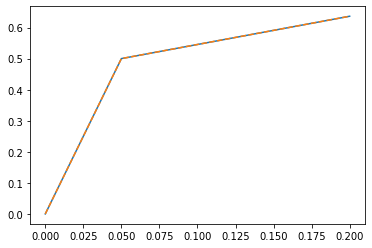

In [31]:
plt.plot(eps_list, sigma_list)
plt.plot(eps_analytic, sigma_analytic, "--")


Redo the computations for a full load cycle, using larger load steps

In [32]:
nsteps = 100
eps_list = np.concatenate((np.linspace(0,0.2,nsteps+1),np.linspace(0.2,-0.2,nsteps+1),np.linspace(-0.2,0.2,nsteps+1)))

epsp_list = [0]
sigma_list = [0]

for i in range(len(eps_list)-1):
    delta_epsp = returnmap(eps_list[i+1], epsp_list[i])
    
    epsp_list.append(epsp_list[i]+delta_epsp)
    sigma_list.append(E*(eps_list[i+1]-epsp_list[i+1]))

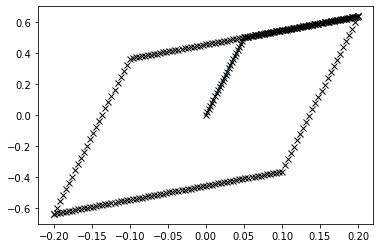

In [33]:
plt.plot(eps_analytic, sigma_analytic)
plt.plot(eps_list, sigma_list, "kx")

### Stress-driven loading and tangent stiffnesses

In the following, we assume that load-stepping by increasing or decreasing stress is performed. This is closer to numerical simulations using FEM, where usually external loads are forces or moments acting on surfaces of in volumes.

A notion we need is the residual stress, for given strains $\varepsilon$, $\varepsilon_p$ and stress $\sigma$ it evaluates to
$$r = \sigma - E(\varepsilon - \varepsilon_p)$$
In a finite element method, this corresponds to computing the residual vector of the system of equations.

Moreover, we need the tangent modulus, which corresponds to the derivative seen in the stress/strain curve. The tangent modulus needs to be derived correctly depending on the stiffnesses and yield condition. If it is not correct, the convergence of the iterative process slows down.

The strain update $\Delta \varepsilon$ is computed in an iterative manner. Starting from $\Delta \varepsilon^{(0)}$ and $\Delta \varepsilon_p^{(0)}$, in each step $k$
* compute the return map update $\delta \varepsilon_p$ for inputs $\varepsilon_n + \Delta \varepsilon^{(k)}$ and $\varepsilon_{p,n} + \Delta \varepsilon_p^{(k)}$, and update the plastic strain accordingly
$$\Delta \varepsilon_p^{(k+1)} = \Delta \varepsilon_p^{(k)} + \delta \varepsilon_p$$
* compute the driving stress 
$$\hat \sigma^{(k)}_{n+1} = E(\varepsilon_n + \Delta \varepsilon^{(k)} - (\varepsilon_{p,n} + \Delta \varepsilon_p^{(k+1)} )) - H(\varepsilon_{p,n} + \Delta \varepsilon_p^{(k+1)})$$
* and the residual stress 
$$r = \sigma_{n+1} - E(\varepsilon_n + \Delta \varepsilon^{(k)} - (\varepsilon_{p,n} + \Delta \varepsilon_p^{(k+1)}))$$
* estimate the necessary strain update using the tangent modulus $E_T$, and update the strain accordingly
$$\delta \varepsilon = \frac{r}{E_T}, \qquad \Delta \varepsilon^{(k+1)} = \Delta \varepsilon^{(k)} + \delta \varepsilon$$





In [34]:
def computeresidualstress(eps, epsp, sigma):
    return sigma - E*(eps-epsp)

def computetangentmodulus(sigma_hat, delta_epsp):
    if fhat(sigma_hat)<-1e-10 or np.sign(sigma_hat)*delta_epsp<1e-10: 
        return E
    else: 
        return 1.1*H*E/(E+H)

Load step 0: stress 0.031818181818181815
step 0: updates =  0.0031818181818181815 0
step 1: updates =  0.0 0
Load step 1: stress 0.06363636363636363
step 0: updates =  0.0031818181818181815 0
step 1: updates =  0.0 0
Load step 2: stress 0.09545454545454544
step 0: updates =  0.0031818181818181815 0
step 1: updates =  0.0 0
Load step 3: stress 0.12727272727272726
step 0: updates =  0.0031818181818181815 0
step 1: updates =  0.0 0
Load step 4: stress 0.15909090909090906
step 0: updates =  0.00318181818181818 0
step 1: updates =  0.0 0
Load step 5: stress 0.1909090909090909
step 0: updates =  0.003181818181818183 0
step 1: updates =  0.0 0
Load step 6: stress 0.22272727272727272
step 0: updates =  0.003181818181818183 0
step 1: updates =  0.0 0
Load step 7: stress 0.2545454545454545
step 0: updates =  0.00318181818181818 0
step 1: updates =  0.0 0
Load step 8: stress 0.2863636363636363
step 0: updates =  0.00318181818181818 0
step 1: updates =  0.0 0
Load step 9: stress 0.3181818181818181

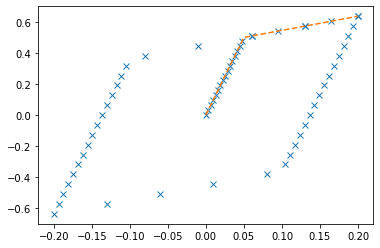

In [35]:
max_stress = stress(0.2)

# nsteps = 10
# stress_list_rm = np.linspace(0,max_stress,nsteps+1)

nsteps = 20
stress_list_rm = np.concatenate((np.linspace(0,max_stress,nsteps, endpoint=False),np.linspace(max_stress,-max_stress,nsteps, endpoint=False),np.linspace(-max_stress,max_stress,nsteps+1)))

eps_list_rm = [0]
epsp_list_rm = [0]

tangent_modulus = E
for i in range(len(stress_list_rm)-1):

    print(f"Load step {i}: stress {stress_list_rm[i+1]}")
    Delta_eps = 0
    Delta_epsp = 0

    for k in range(100):

        ## compute return map update delta_epsp
        delta_epsp = returnmap(eps_list_rm[i]+Delta_eps, epsp_list_rm[i]+Delta_epsp)
        Delta_epsp += delta_epsp

        ## compute driving stress
        sigma_hat = E*(eps_list_rm[i] + Delta_eps) - (E+H)*(epsp_list_rm[i] + Delta_epsp)

        ## current tangent modulus
        tangent_modulus = computetangentmodulus(sigma_hat, Delta_epsp)

        ## compute residual stress
        residual_stress = computeresidualstress(eps_list_rm[i]+Delta_eps, epsp_list_rm[i]+Delta_epsp, stress_list_rm[i+1])

        ## estimate strain update using tangent modulus
        delta_eps = residual_stress/tangent_modulus
        Delta_eps += delta_eps

        print(f"step {k}: updates = ", delta_eps, delta_epsp)

        if np.abs(delta_epsp) < 1e-10 and np.abs(delta_eps) < 1e-10: break

    eps_list_rm.append(eps_list_rm[i] + Delta_eps)
    epsp_list_rm.append(epsp_list_rm[i] + Delta_epsp)
        
plt.plot(eps_list_rm, stress_list_rm, "x")
plt.plot(eps_analytic, sigma_analytic, "--")


### Numerics based on variational inequality

We use the minimization property of the variational inequality, in each time step
$$\dot \psi + \phi(\dot \varepsilon_p) - \sigma \dot \varepsilon \to \min_{\dot \varepsilon, \dot \varepsilon_p}$$

Helmholtz free energy and dissipation function for the linear kinematic hardening model are easily implemented,
$$\psi = \frac{E}{2} (\varepsilon - \varepsilon_p)^2 + \frac{H}{2} \varepsilon_p^2,\qquad
\phi = \sigma_Y |\dot \varepsilon_p|$$

We test the approach with respect to its possibilities of generic implementation. In absence of rate-dependence, we assume the time step size $\Delta t = 1$, such that rates in time increment $t_n \to t_{n+1} = t_n + \Delta t$ are approximated
$$\dot \varepsilon \simeq \Delta \varepsilon,\qquad
\dot \varepsilon_p \simeq \Delta \varepsilon_p,\qquad
\dot \psi \simeq \psi(\varepsilon_n +\Delta \varepsilon, \varepsilon_{p,n}+ \Delta \varepsilon_p) - \psi(\varepsilon_n, \varepsilon_{p,n}),\qquad
\phi \simeq \sigma_Y |\Delta \varepsilon_p|.$$

Then, we choose an optimization solver implemented in scipy that is suitable for non-differentiable optimization. 

In [36]:
def psi(eps, epsp):
    return 1/2*E*(eps-epsp)**2 + 1/2*H*epsp**2

def delta_psi(eps, epsp, delta_eps, delta_epsp):
    return psi(eps+delta_eps,epsp+delta_epsp) - psi(eps,epsp)
    

def phi(delta_epsp):
    return sigmaY*np.abs(delta_epsp)

def objective_function(x, eps, epsp, sigma):
    delta_eps = x[0]
    delta_epsp = x[1]

    return delta_psi(eps, epsp, delta_eps, delta_epsp) + phi(delta_epsp) - sigma*delta_eps

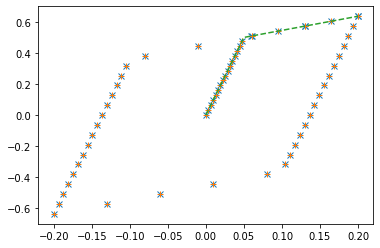

In [39]:
from scipy.optimize import minimize


nsteps = 20
stress_list_vi = np.linspace(0,max_stress,nsteps+1)
stress_list_vi = np.concatenate((np.linspace(0,max_stress,nsteps, endpoint=False),np.linspace(max_stress,-max_stress,nsteps, endpoint=False),np.linspace(-max_stress,max_stress,nsteps+1)))

eps_list_vi = [0]
epsp_list_vi = [0]


for i in range(len(stress_list_vi)-1):
    x0 = np.array([0,0])

    result = minimize(objective_function, x0, (eps_list_vi[i], epsp_list_vi[i], stress_list_vi[i+1]), method="Powell")

    eps_list_vi.append(eps_list_vi[i]+result.x[0])
    epsp_list_vi.append(epsp_list_vi[i]+result.x[1])
    if not result.success:
        print("scipy minimization failed")
        break

plt.plot(eps_list_vi, stress_list_vi, "x")
plt.plot(eps_list_rm, stress_list_rm, "+")
plt.plot(eps_analytic, sigma_analytic, "--")